 $\def\sgn{\text{sgn}}$

# Trainining Support Vector Machines

In this notebook, I will demonstrate the training of SVM for a two-class classification problem.

Recall the problem : we are given a collection of points $x_1,\ldots x_K$ in $\mathbb{R}^n$ with labels $y_1,\ldots, y_K$ taking values from the set $\{-1,1\}$. Given these observations, we would like to classify a point $x\in \mathbb{R}^n$, i.e., decide which of the two classes $\{-1,1\}$ that $x$ belongs to. For this, we look for a function $f(x)$ such that
 $\sgn(f(x))$ assignes the class for $x$. 
 
Naturally, we would like the function to correctly classify the provided data. That is, we would like $\sgn(f(x_i)) = y_i$. However, taking into account the possibility of outliers in data, we will not enforce this as a constraint. Rather, we will be content if $\sgn(f(x_i)) = y_i$ for most of the data points. 

Recall that, $f$ is of the form
$$
f(x) = \sum_i \,\alpha_i\,y_i\,K(x,x_i) + b,
$$
where $K$ is a given Kernel and $\alpha_i$ and $b$ are constants to be learned from data. We will work with the Gaussian kernel and "learn" the parameters $\alpha_i$ and $b$ by solving a minimization problem. Recall that the Gaussian kernel $K(u,v)$ is defined as
$$
K(u,v) = \exp\left( -\| u - v\|_2^2 / \sigma^2 \right).
$$
In this definition, $\sigma^2$ is a parameter of the kernel, to be chosen by us.

The minimization problem, the solution of which determines $\alpha$ and $b$, is
$$
min_{\alpha} \frac{1}{2} \langle \alpha,H \alpha\rangle - \langle 1,\alpha \rangle, \text{ subject to } \begin{cases}\langle\alpha,y \rangle = 0,\\
\alpha_i \geq 0, \text{ for all } i.
\end{cases}
$$
Here, the $H$ is a $K \times K$ psd matrix whose $(i,j)$ entry is 
$$
H(i,j) = y_i\,y_j\,\left( K(x_i,x_j) + \frac{1}{C}\delta_{i,j} \right)
$$
In this formulation, $C$  and $\sigma^2$ constitute the parameters of the formulation.

If $\alpha^*$ denotes the solution of the problem above, the value of the optimal $b^*$ is found so that $f(x_i) = (1 - \alpha^*_i/C) / y_i$ is satisfied for any $i$ such that $\alpha^*_i > 0$.

Let us now produce some data and see how well the proposed formulation works.

## Example-1 :
Our first example involves a relatively simple partition.

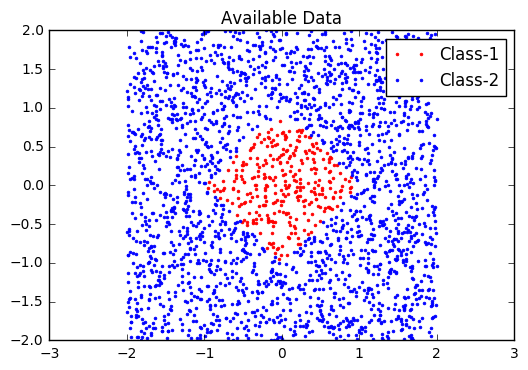

In [1]:
import numpy as np
import SVM
import matplotlib.pyplot as plt

def diamondF( x, R ):
    # assigns 1 if x lies inside a diamond of radius R (around the origin)
    y = np.ones(x.shape[1])
    y[(abs(x[0,:]) + abs(x[1,:])) > R ]  = -1
    return y

N = 2500 # number of points
x = np.random.uniform(-2,2,(2,N))
y = diamondF(x,1)

plt.plot(x[0, y == 1], x[1,y == 1], 'ro', markersize = 2, markeredgecolor = 'r', label = 'Class-1')
plt.plot(x[0, y == -1], x[1,y == -1], 'bo', markersize = 2, markeredgecolor = 'b', label = 'Class-2')
plt.legend()
plt.axis('equal')
plt.title('Available Data')
plt.show()

Be careful -- in practice, we are given just $x$ and $y$. This is a collection of numbers. We normally do not know from the onset that the first class consists of points inside a diamond etc. But we hope that, somehow, the 'learned' parameters will reveal that.

The training function requires the matrix $H$, which depends on the data. Let us now construct that. 

In [2]:
H = np.zeros((N,N))
sig = 1.0
C = 10.0
for n in range(0,N):
    for k in range(0,N):
        H[n,k] = np.exp(- sum( (x[:,n] - x[:,k])**2) / (sig**2) ) * y[n] * y[k]
    H[n,n] += 1.0 / C

We are now ready for the training phase. The optimization problem above is solved using the forward backward splitting algorithm. The forward step consists of a linear adjustment and can be implemented easily. The backward step requires a projection onto the constraint set. This can be achieved with a finite terminating algorithm, as will be discussed in class.

In [3]:
MAX_ITER = 2000
alp = SVM.SVMdual_FB(H, y, MAX_ITER)

 SVM training : [||||||||||] 100% Complete


In order to implement the function $f$, we only need the support vectors (i.e., $x_i$, $y_i$ such that $\alpha_i >0$.). Let us extract those.

In [4]:
# only need the support vectors for classification
ind = alp > 1e-5
alpsup = alp[ind]
ysup = y[ind]
xsup = x[:,ind]

Let us also determine the constant $b$. Remember that $b$ must satisfy  $f(x_i) = (1 - \alpha^*_i/C) / y_i$ for any $\alpha_i>0$. We also declare $f$ for convenience.

In [5]:
# the classification function based on the Gaussian Kernel
def Gaussf(z, alp, x, y, sig, b):
    f = b + sum( alp * y * np.exp( -1.0 * sum( (x - z)**2 ) / ( sig**2 ) ) ) 
    return f

# determine b
k = np.argmax(alpsup)
b = 0
f = Gaussf(xsup[:,k].reshape((2,1)), alpsup, xsup, ysup, sig, b)
b = (1 - alpsup[k] / C ) / y[k] - f

We are now ready to view the function $f$ as well as the partition implied by $f$, i.e., the regions $f(x) > 0$ and $f(x)<0$.

In [6]:
# construct a grid
xx, yy = np.meshgrid( np.arange(-3, 3, 0.05), np.arange(-3, 3, 0.05) )
# rearrange the coordinates into a (2xM) array, where M is the number of points in the mesh
t = np.concatenate( ( xx.reshape((1,xx.size)), yy.reshape((1,yy.size)) ), axis = 0 )

f = np.zeros(xx.size) # the function array to be filled

for k in range(0, xx.size):
    f[k] = Gaussf(t[:,k].reshape((2,1)), alpsup, xsup, ysup, sig, b)

f = f.reshape( (xx.shape[0], xx.shape[1]) )

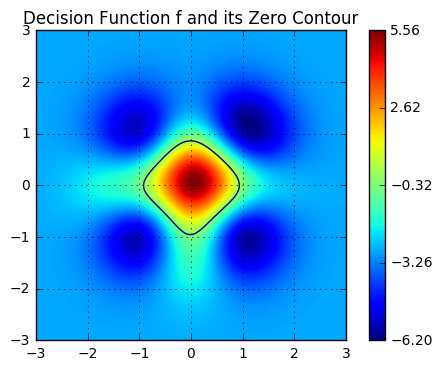

In [7]:
fig = plt.figure()
im = plt.imshow(f, interpolation='bilinear', origin='lower', extent=[-3, 3, -3, 3],
                vmax=f.max(), vmin=f.min())
plt.contour(xx,yy,f,[0.0])
fig.colorbar(im, ticks = np.linspace(f.min(), f.max(), num=5))
plt.title('Decision Function f and its Zero Contour')
plt.grid()
plt.show()

Notice that in the figure above, the zero level is indicated with a contour. Ideally, we would like that to be a diamond of size 1. However, since we have limited data, we need to use a regularization parameter $C$, which in turn leads to a smoother contour.

## Example-2 :
We now consider a slightly more complicated partition.

In [8]:
# the sinusoidal support function
def sinF( x, t, R ):
    # assigns 1 if x lies inside a diamond of radius R (around the origin)
    y = np.ones(x.shape[1])
    y[ np.sin( np.pi * x[0,:]) + t < x[1,:]  ]  = -1
    y[ np.sin( np.pi * x[0,:]) - t > x[1,:]  ]  = -1
    y[(x[0,:]**2 + x[1,:]**2) > R**2 ]  = -1
    return y

We will use the same $x$ points but use different labels.

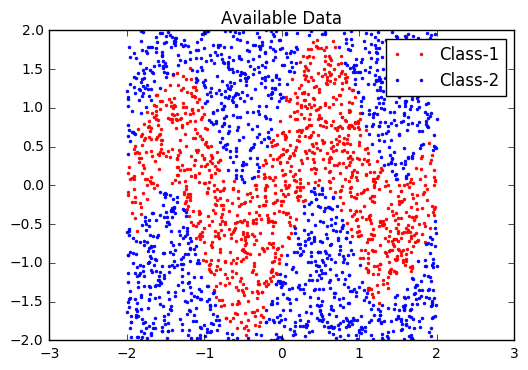

In [9]:
y = sinF(x,1,2)

fig = plt.figure()
plt.plot(x[0, y == 1], x[1,y == 1], 'ro', markeredgecolor='r', markersize = 2, label = 'Class-1')
plt.plot(x[0, y == -1], x[1,y == -1], 'bo', markeredgecolor='b', markersize = 2, label = 'Class-2')
plt.legend()
plt.axis('equal')
plt.title('Available Data')
plt.show()

Let us construct the matrix $H$. Notice that we now employ a more compact code and use different values for the parameters $C$ and $\sigma^2$.

In [10]:
# construct the H matrix that SVMtrain_FB requires
# set the parameters
sig = 0.5 
C = 10.0
# compute H
dist = ( ( np.tile(x[0,:],(N,1)) -  np.tile(x[0,:],(N,1)).transpose() )**2 \
        + ( np.tile(x[1,:],(N,1)) -  np.tile(x[1,:],(N,1)).transpose() )**2 )
Y = np.tile(y,(N,1)) * np.tile(y,(N,1)).transpose()
H = ( np.exp(- dist / (sig**2) ) + np.identity(N) / C ) * Y 

Constructing $H$ this way takes much less time...

In [11]:
# train!
alp = SVM.SVMdual_FB(H, y, MAX_ITER)

 SVM training : [||||||||||] 100% Complete


In [12]:
# only need the support vectors for classification
ind = alp > 1e-5
alpsup = alp[ind]
ysup = y[ind]
xsup = x[:,ind]

# determine b
k = np.argmax(alpsup)
b = 0
f = Gaussf(xsup[:,k].reshape((2,1)), alpsup, xsup, ysup, sig, b)
b = (1 - alpsup[k] / C ) / y[k] - f

Now that we have the parameters, let us view the decision function $f$.

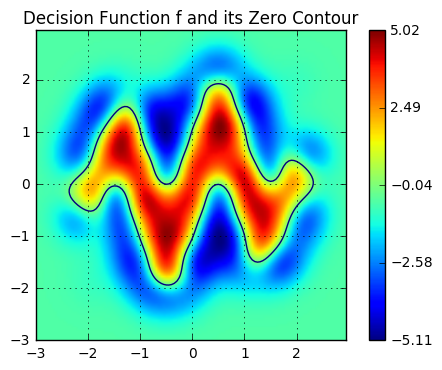

In [13]:
# display the results
grid = np.arange(-3, 3, 0.05)
xx, yy = np.meshgrid(grid, grid)
t = np.concatenate((xx.reshape((1,xx.size)),yy.reshape((1,yy.size))),axis = 0)
f = np.zeros(xx.size)

for k in range(0, xx.size):
    f[k] = Gaussf(t[:,k].reshape((2,1)), alpsup, xsup, ysup, sig, b)

f = f.reshape((xx.shape[0],xx.shape[1]))


fig = plt.figure()
im = plt.imshow(f, interpolation='bilinear', origin='lower', extent=[min(grid), max(grid), min(grid), max(grid)],
                vmax=f.max(), vmin=f.min())
plt.contour(xx,yy,f,[0.0])
fig.colorbar(im, ticks = np.linspace(f.min(), f.max(), num=5))
plt.title('Decision Function f and its Zero Contour')
plt.grid()
plt.show()

In order to understand the influence of the parameters, I suggest you to try different values of $C$ and $\sigma^2$.

*Ilker Bayram, Istanbul Teknik Universitesi, 2016*.